In [6]:
import tensorflow as tf

In [7]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3
BATCH_SIZE = 32
EPOCHS = 20
DATA_SOURCE_TRAIN = 'data/malhari/train'
DATA_SOURCE_TEST = 'data/malhari/test'

In [8]:
import matplotlib.pyplot as plt

def show_model_performance(history):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']

    subplots = [
        {
            'title': 'Accuracy',
            'plots': [
                {
                    'label': 'Training',
                    'data': acc
                },
                {
                    'label': 'Validation',
                    'data': val_acc,
                }
            ]
        },
        {
            'title': 'Loss',
            'plots': [
                {
                    'label': 'Training',
                    'data': loss
                },
                {
                    'label': 'Validation',
                    'data': val_loss,
                }
            ]
        }
    ]

    if 'learning_rate' in history:
        subplots.append({
            'title': 'Learning Rate',
            'plots': [
                {
                    'label': 'Learning rate',
                    'data': history['learning_rate'],
                }
            ]
        })

    plt.figure(figsize=(12, 5))

    for idx, subplot in enumerate(subplots):
        plt.subplot(1, len(subplots), idx + 1)

        for plot in subplot['plots']:
            plt.plot(plot['data'], label=plot['label'])

        plt.title(subplot['title'])
        plt.xlabel('Epoch')
        plt.ylabel(subplot['title'])
        plt.legend()

    plt.tight_layout()
    plt.show()

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_SOURCE_TRAIN,
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_SOURCE_TEST,
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names

Found 2630 files belonging to 3 classes.
Found 297 files belonging to 3 classes.


In [16]:
vgg16 = tf.keras.applications.VGG16(
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3),
    weights='imagenet',
    include_top=False,
)

for layer in vgg16.layers[:-3]: layer.trainable = False

input = vgg16.layers[-1].output

x = tf.keras.layers.Dropout(0.25)(input)
x = tf.keras.layers.Flatten()(x)
output = tf.keras.layers.Dense(len(train_ds.class_names), activation='softmax')(x)

vgg16_model = tf.keras.Model(vgg16.input, output)

base_learning_rate = 0.0001
vgg16_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'checkpoints/malhari_vgg16_best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

initial_epochs = 10

vgg16_model.summary(show_trainable=True)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_5 (InputLayer)  │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv1 (Conv2D)       │ (None, 224, 224, 64)  │      1,792 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv2 (Conv2D)       │ (None, 224, 224, 64)  │     36,928 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_pool (MaxPooling2D)  │ (None, 112, 112, 64)  │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv1 (Conv2D)       │ (None, 112, 112, 128) │     73,856 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv2 (Conv2D)       │ (None, 112, 112, 128) │    147,584 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_pool (MaxPooling2D)  │ (None, 56, 56, 128)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv1 (Conv2D)       │ (None, 56, 56, 256)   │    295,168 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv2 (Conv2D)       │ (None, 56, 56, 256)   │    590,080 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv3 (Conv2D)       │ (None, 56, 56, 256)   │    590,080 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_pool (MaxPooling2D)  │ (None, 28, 28, 256)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv1 (Conv2D)       │ (None, 28, 28, 512)   │  1,180,160 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv2 (Conv2D)       │ (None, 28, 28, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv3 (Conv2D)       │ (None, 28, 28, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_pool (MaxPooling2D)  │ (None, 14, 14, 512)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv1 (Conv2D)       │ (None, 14, 14, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv2 (Conv2D)       │ (None, 14, 14, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv3 (Conv2D)       │ (None, 14, 14, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_pool (MaxPooling2D)  │ (None, 7, 7, 512)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_5 (Dropout)         │ (None, 7, 7, 512)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten_5 (Flatten)         │ (None, 25088)         │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_5 (Dense)             │ (None, 3)             │     75,267 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 14,789,955 (56.42 MB)

 Trainable params: 4,794,883 (18.29 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

In [11]:
vgg16_history = vgg16_model.fit(
    train_ds,
    epochs=initial_epochs,
    validation_data=val_ds,
    callbacks=callbacks
)

print(vgg16_history.history)

vgg16_model.save('models/malhari_transfer_vgg16.keras')
print("Model saved successfully")

Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4850 - loss: 9.3276
Epoch 1: val_loss improved from inf to 2.31393, saving model to checkpoints/malhari_vgg16_best_model.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 581s 7s/step - accuracy: 0.4865 - loss: 9.2729 - val_accuracy: 0.6498 - val_loss: 2.3139 - learning_rate: 1.0000e-04
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8227 - loss: 0.9919
Epoch 2: val_loss improved from 2.31393 to 1.51380, saving model to checkpoints/malhari_vgg16_best_model.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 577s 7s/step - accuracy: 0.8229 - loss: 0.9899 - val_accuracy: 0.6970 - val_loss: 1.5138 - learning_rate: 1.0000e-04
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8977 - loss: 0.4116
Epoch 3: val_loss did not improve from 1.51380
83/83 ━━━━━━━━━━━━━━━━━━━━ 540s 7s/step - accuracy: 0.8978 - loss: 0.4112 - val_accuracy: 0.7172 - val_loss: 1.9246 - learning_rate: 1.0000e-04
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - acc

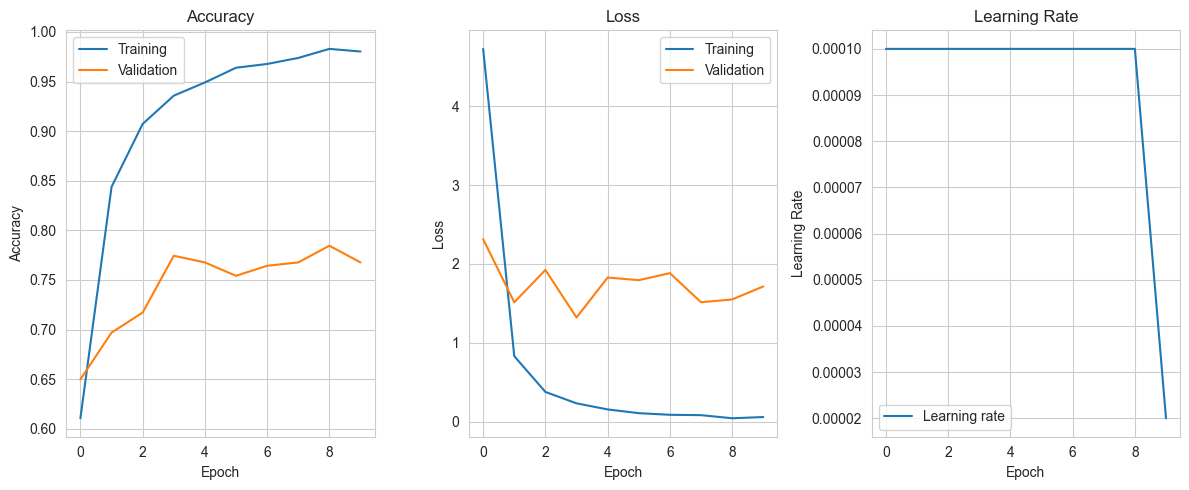

In [12]:
show_model_performance(vgg16_history.history)